<a id="title_ID"></a>
# JWST Pipeline Validation Testing Notebook: MIRI LRS Slit

## Spec2: Extract1d()
<span style="color:red"> **Instruments Affected**</span>: MIRI

### Table of Contents
<div style="text-align: left"> 

<br> [Imports](#imports_ID) <br> [Introduction](#intro_ID) <br> [Get Documentaion String for Markdown Blocks](#markdown_from_docs) <br> [Loading Data](#data_ID) <br> [Run JWST Pipeline](#pipeline_ID) <br> [Create Figure or Print Output](#residual_ID) <br> [About This Notebook](#about_ID) <br>

</div>

<a id="imports_ID"></a>
# Imports
List the library imports and why they are relevant to this notebook.

* os, glob for general  OS operations
* numpy
* astropy.io for opening fits files
* inspect to get the docstring of our objects.
* IPython.display for printing markdown output
* jwst.datamodels for building model for JWST Pipeline
* jwst.module.PipelineStep is the pipeline step being tested
* matplotlib.pyplot to generate plot
* json for editing json files
* crds for retrieving reference files as needed



[Top of Page](#title_ID)

In [146]:
import numpy as np
from numpy.testing import assert_allclose
import os
from glob import glob
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

import astropy.io.fits as fits
import astropy.units as u
import jwst.datamodels as datamodels
from jwst.datamodels import RampModel, ImageModel
from jwst.pipeline import Detector1Pipeline, Spec2Pipeline
from jwst.extract_1d import Extract1dStep
from gwcs.wcstools import grid_from_bounding_box


import json
import crds

from ci_watson.artifactory_helpers import get_bigdata

%matplotlib inline

<a id="intro_ID"></a>
# Introduction


In this notebook we will test the **extract1d()** step of Spec2Pipeline() for **LRS slit** observations.

Step description: https://jwst-pipeline.readthedocs.io/en/stable/jwst/extract_1d/index.html

Pipeline code: https://github.com/spacetelescope/jwst/tree/master/jwst/extract_1d



[Top of Page](#title_ID)

<a id="data_ID"></a>
# Loading Data

We are using here a simulated LRS slit observation, generated with MIRISim v2.3.0 (as of Dec 2020). It is a simple along-slit-nodded observation of a point source (the input was modelled on the flux calibrator BD+60). LRS slit observations cover the full array. 


[Top of Page](#title_ID)

In [147]:
Slitfile1 = get_bigdata('jwst_validation_notebooks',
                                     'validation_data',
                                     'calwebb_spec2',
                                    'spec2_miri_test',
                                    'miri_lrs_slit_pt_nod1_v2.3.fits')
 
Slitfile2 = get_bigdata('jwst_validation_notebooks',
                                     'validation_data',
                                     'calwebb_spec2',
                                    'spec2_miri_test',
                                    'miri_lrs_slit_pt_nod2_v2.3.fits')

#file='det_image_seq1_MIRIMAGE_P750Lexp1.fits'
#input_file1 = get_bigdata('jwst_validation_notebooks',
#                         'validation_data',
#                         'extract_1d',
#                         'extract_1d_miri_test', file)

#files = [input_file1, Slitfile2]
files = [Slitfile1, Slitfile2]



Collect configuration files locally if they aren't yet there.

In [148]:
if not os.path.exists('../cfg_files/'):
    os.mkdir('../cfg_files/')
    cfgs = collect_pipeline_cfgs.collect_pipeline_cfgs(dst='../cfg_files/')

<a id="pipeline_ID"></a>
# Run JWST Pipeline

First we run the data through the Detector1() pipeline to convert the raw counts into slopes. This should use the calwebb_detector1.cfg file. The output of this stage will then be run through the Spec2Pipeline. Extract_1d is the final step of this pipeline stage, so we will just run through the whole pipeline.

[Top of Page](#title_ID)

### Detector1Pipeline

In [149]:
det1 = []

# Run pipeline on both files
for ff in files:
    d1 = Detector1Pipeline.call(ff, save_results=True, config_file='../cfg_files/calwebb_detector1.cfg')
    det1.append(d1)

print(det1)



2020-12-14 22:28:30,433 - CRDS - ERROR -  Error determining best reference for 'pars-rscd_step'  =   Unknown reference type 'pars-rscd_step'
2020-12-14 22:28:30,478 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2020-12-14 22:28:30,479 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2020-12-14 22:28:30,481 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2020-12-14 22:28:30,482 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2020-12-14 22:28:30,483 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2020-12-14 22:28:30,484 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2020-12-14 22:28:30,486 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2020-12-14 22:28:30,487 - stpipe.Detector1Pipeline.rscd - INFO - RSCD_Step instance created.
2020-12-14 22:28:30,488 - stpipe.Detector1Pipeline.firstframe - INFO - First

2020-12-14 22:28:31,008 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/skendrew//crds_cache/references/jwst/miri/jwst_miri_readnoise_0057.fits'.
2020-12-14 22:28:31,009 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2020-12-14 22:28:31,009 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/Users/skendrew//crds_cache/references/jwst/miri/jwst_miri_rscd_0010.fits'.
2020-12-14 22:28:31,010 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/Users/skendrew//crds_cache/references/jwst/miri/jwst_miri_saturation_0022.fits'.
2020-12-14 22:28:31,010 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2020-12-14 22:28:31,011 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2020-12-14 22:28:31,011 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2020-12-14 22:28:31,012 - stp

2020-12-14 22:28:37,847 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /Users/skendrew//crds_cache/references/jwst/miri/jwst_miri_dark_0058.fits
2020-12-14 22:28:41,386 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=2, ngroups=10, nframes=1, groupgap=0
2020-12-14 22:28:41,387 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0
2020-12-14 22:28:43,236 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2020-12-14 22:28:44,051 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).
2020-12-14 22:28:44,052 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'sea

2020-12-14 22:29:09,772 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2020-12-14 22:29:09,773 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2020-12-14 22:29:09,775 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2020-12-14 22:29:09,777 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2020-12-14 22:29:09,779 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2020-12-14 22:29:09,781 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2020-12-14 22:29:09,782 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2020-12-14 22:29:09,784 - stpipe.Detector1Pipeline.rscd - INFO - RSCD_Step instance created.
2020-12-14 22:29:09,785 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2020-12-14 22:29:09,787 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2020-12-14 

2020-12-14 22:29:10,271 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2020-12-14 22:29:10,272 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/Users/skendrew//crds_cache/references/jwst/miri/jwst_miri_rscd_0010.fits'.
2020-12-14 22:29:10,272 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/Users/skendrew//crds_cache/references/jwst/miri/jwst_miri_saturation_0022.fits'.
2020-12-14 22:29:10,273 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2020-12-14 22:29:10,273 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2020-12-14 22:29:10,274 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2020-12-14 22:29:10,274 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...
2020-12-14 22:29:10,753 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(2,

2020-12-14 22:29:18,974 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=2, ngroups=10, nframes=1, groupgap=0
2020-12-14 22:29:18,975 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0
2020-12-14 22:29:20,085 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2020-12-14 22:29:20,906 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).
2020-12-14 22:29:20,908 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/skendrew/jwst_pipeline/jwst_validation_notebooks/jwst_validation_notebooks/extract1d', 'odd_even_columns': True, 'use_side_ref_p

[<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_rate.fits>, <ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_rate.fits>]


### Spec2Pipeline

Next we go ahead to the Spec2 pipeline. At this stage we perform 2 tests:

1. run the Spec2 pipeline on one single exposure, extracting over the full bounding box width. we compare this with the manual extraction over the same aperture. this tests whether the pipeline is performing the correct arithmetic in the extraction procedure.
2. run the Spec2 pipeline on the nodded set of exposures. this mimics more closely how the pipeline will be run in automated way during routine operations. this will test whether the pipeline is finding the source positions, and is able to extract both nodded observations in the same way.

The initial steps will be the same for both tests and will be run on both initially.


In [150]:
spec2 = []
for dd in det1:
    s2 = Spec2Pipeline.call(dd.meta.filename, config_file='../cfg_files/calwebb_spec2.cfg', steps={"extract_1d": {"skip": True}})
    spec2.append(s2)


2020-12-14 22:31:16,220 - stpipe - WARNING - /Users/skendrew/anaconda3/envs/jwst0.16.2/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)

2020-12-14 22:31:16,397 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2020-12-14 22:31:16,399 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2020-12-14 22:31:16,400 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2020-12-14 22:31:16,402 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2020-12-14 22:31:16,404 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2020-12-14 22:31:16,405 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract

2020-12-14 22:31:16,884 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2020-12-14 22:31:16,884 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2020-12-14 22:31:16,885 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2020-12-14 22:31:16,885 - stpipe.Spec2Pipeline - INFO - Prefetch for CUBEPAR reference file is 'N/A'.
2020-12-14 22:31:16,886 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2020-12-14 22:31:16,886 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.
2020-12-14 22:31:16,887 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/Users/skendrew//crds_cache/references/jwst/miri/jwst_miri_distortion_0028.asdf'.
2020-12-14 22:31:16,887 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/Users/skendrew//crds_cache/references/jwst/miri/jwst_miri_drizpars_0001.fits'.
2020-12-14 22:31:16,888 - 

2020-12-14 22:31:20,097 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A
2020-12-14 22:31:20,192 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI
2020-12-14 22:31:20,193 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIMAGE
2020-12-14 22:31:20,193 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_LRS-FIXEDSLIT
2020-12-14 22:31:20,194 - stpipe.Spec2Pipeline.photom - INFO -  filter: P750L
2020-12-14 22:31:20,212 - stpipe.Spec2Pipeline.photom - INFO -  subarray: FULL
2020-12-14 22:31:20,213 - stpipe.Spec2Pipeline.photom - INFO - PHOTMJSR value: 60.567
2020-12-14 22:31:20,302 - stpipe.Spec2Pipeline.photom - INFO - Step photom done
2020-12-14 22:31:20,962 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2_cal.fits>,).
2020-12-14 22:31:20,965 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'outpu

2020-12-14 22:31:23,935 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'miri_lrs_slit_pt_nod2_v2.3_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'resol', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']
2020-12-14 22:31:23,938 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2020-12-14 22:31:23,939 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2020-12-14 22:31:23,939 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2020-12-14 22:31:23,939 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2020-12-14 22:31:23,940 - stpipe.Spec2Pipeline - INFO - Prefetch for CUBEPAR reference file is 'N/A'.
2020-12-14 22:3

2020-12-14 22:31:27,000 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_rate.fits>,).
2020-12-14 22:31:27,003 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2020-12-14 22:31:27,018 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /Users/skendrew//crds_cache/references/jwst/miri/jwst_miri_photom_0072.fits
2020-12-14 22:31:27,021 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A
2020-12-14 22:31:27,114 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI
2020-12-14 22:31:27,114 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIMAGE
2020-12-14 22:31:27,115 - stpipe.Spec2Pipeline.photom - INFO -

In [156]:
calfiles = glob('*_cal.fits')
print(calfiles)
photom = []
nods = []

for cf in calfiles:
    if 'nod1' in cf:
        nn = 'nod1'
    else:
        nn = 'nod2'
    ph = datamodels.open(cf)
    photom.append(ph)
    nods.append(nn)
    
print(photom)

['miri_lrs_slit_pt_nod2_v2_cal.fits', 'miri_lrs_slit_pt_nod1_v2_cal.fits']
[<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2_cal.fits>, <ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2_cal.fits>]


Retrieve the wcs information from the PHOTOM output file so we know the coordinates of the bounding box and the wavelength grid. We use the ``grid_from_bounding_box`` function to generate these grids. We convert the wavelength grid into a wavelength vector by averaging over each row. This works because LRS distortion is minimal, so lines of equal wavelength run along rows (not 100% accurate but for this purpose this is correct).

This cell performs a check that both nods have the same wavelength assignment over the full bounding box, which is expected.

In [165]:
lams = []

for ph,nn in zip(photom, nods):

    bbox_w = ph.meta.wcs.bounding_box[0][1] - ph.meta.wcs.bounding_box[0][0]
    bbox_ht = ph.meta.wcs.bounding_box[1][1] - ph.meta.wcs.bounding_box[1][0]
    print('Model bbox ({1}) = {0} '.format(ph.meta.wcs.bounding_box, nn))
    print('Model: Height x width of bounding box ({2})= {0} x {1} pixels'.format(bbox_ht, bbox_w, nn))

    x,y = grid_from_bounding_box(ph.meta.wcs.bounding_box)
    ra, dec, lam = ph.meta.wcs(x, y)

    lam_vec = np.mean(lam, axis=1)
    lams.append(lam_vec)
    
# check that the wavelength vectors for the nods are equal, then we can just work with one going forward
assert np.array_equal(lams[0], lams[1], equal_nan=True), "Arrays not equal!"

Model bbox (nod2) = ((302.5, 346.5), (6.5, 396.5)) 
Model: Height x width of bounding box (nod2)= 390.0 x 44.0 pixels
Model bbox (nod1) = ((302.5, 346.5), (6.5, 396.5)) 
Model: Height x width of bounding box (nod1)= 390.0 x 44.0 pixels


#### Test 1: Single exposure, full width extraction

To enable the extraction over the full width of the LRS slit bounding box, we have to edit the json parameters file and run the step with an override to the config file. We first run the Spec2Pipeline with its default settings, skipping the extract_1d() step.

**The next few steps will be executed with one of the nods only.** Next we perform a manual extraction by first extracting the bounding box portion of the array, and then summing up the values in each row over the full BB width. This returns the flux in MJy/sr, which we convert to Jy using the pixel area. A MIRI imager pixel measures 0.11" on the side.

**NOTE: the current pipeline step applies a nod offset of -8.284xxx pix or +8.805xxx pix for nod1, nod 2 respectively, regardless of what's in the json file. I have added this offset to this test to demonstrate that we understand and are able to macth the pipeline very closely, but this will very likely need updating as it is not realistic.**

In [186]:
ph1 = photom[0]
nn = nods[0]
print('The next steps will be run only on {0}, the {1} exposure'.format(ph1.meta.filename, nn))

if (nn == 'nod1'):
    offset = -8.28479
else:
    offset = 8.80479

photom_sub = ph1.data[np.int(np.min(y)):np.int(np.max(y)+1), np.int(np.min(x)+offset):np.int(np.max(x)+1+offset)]
print('Cutout has dimensions ({0})'.format(np.shape(photom_sub)))
print('The cutout was taken from pixel {0} to pixel {1} in x'.format(np.int(np.min(x)+offset),np.int(np.max(x)+1+offset)))

xsub = np.sum(photom_sub, axis=1)

#remove some nans
lam_vec = lams[0]
xsub = xsub[~np.isnan(lam_vec)]
lam_vec = lam_vec[~np.isnan(lam_vec)]

# calculate the pixel area in sr
pix_scale = 0.11 * u.arcsec
pixar_as2 = pix_scale**2
pixar_sr = pixar_as2.to(u.sr)

# now convert flux from MJy/sr to Jy using the pixel area
if (ph1.meta.bunit_data == 'MJy/sr'):
    xsub_cal = xsub * pixar_sr.value * 1e6

print(len(lam_vec))


The next steps will be run only on miri_lrs_slit_pt_nod2_v2_cal.fits, the nod2 exposure
Cutout has dimensions ((390, 44))
The cutout was taken from pixel 311 to pixel 355 in x
387


Next we run the ``extract_1d()`` step on the same file, editing the configuration to sum up over the entire aperture as we did above. We load in the json file, make ajustments and run the step with a config file override option.

In [187]:
extreffile='jwst_miri_extract1d_0004.json'
basename=crds.core.config.pop_crds_uri(extreffile)
path=crds.locate_file(basename,"jwst")
with open(path) as json_ref:
    jsreforig = json.load(json_ref)
    jsrefdict = jsreforig.copy()
    jsrefdict['apertures'][0]['xstart'] = np.int(np.min(x))
    jsrefdict['apertures'][0]['xstop'] = np.int(np.max(x)) + 1
    
    for element in jsrefdict['apertures']:
        element.pop('extract_width', None)
        element.pop('nod2_offset', None)

with open('extract1d_fs2b75.json','w') as jsrefout:
    json.dump(jsrefdict,jsrefout,indent=4)

In [188]:
with open('extract_1d_fs2b75.cfg','w') as cfg:
    cfg.write('name = "extract_1d"'+'\n')
    cfg.write('class = "jwst.extract_1d.Extract1dStep"'+'\n')
    cfg.write(''+'\n')
    cfg.write('log_increment = 50'+'\n')
    cfg.write('smoothing_length = 0'+'\n')
    cfg.write('override_extract1d="extract1d_fs2b75.json"'+'\n')

In [189]:
xsub_pipe = Extract1dStep.call(ph1, config_file='extract_1d_fs2b75.cfg', save_results=True)

2020-12-15 15:10:50,812 - stpipe.extract_1d - INFO - Extract1dStep instance created.
2020-12-15 15:10:51,161 - stpipe.extract_1d - INFO - Step extract_1d running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2_cal.fits>,).
2020-12-15 15:10:51,164 - stpipe.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': 0, 'bkg_order': None, 'log_increment': 50, 'subtract_background': None, 'apply_nod_offset': None}
2020-12-15 15:10:51,176 - stpipe.extract_1d - INFO - Using EXTRACT1D reference file /Users/skendrew/jwst_pipeline/jwst_validation_notebooks/jwst_validation_notebooks/extract1d/extract1d_fs2b75.json
2020-12-15 15:10:51,201 - stpipe.extract_1d - WARNING - spectral_order is None; using 1
2020-12-15 15:10:51,

If the step ran successfully, we can now look at the output and compare to our manual extraction spectrum. To ratio the 2 spectra we interpolate the manually extracted spectrum ``xsub_cal`` onto the pipeline-generated wavelength grid. 

2020-12-15 15:10:56,045 - stpipe - WARNING - /Users/skendrew/anaconda3/envs/jwst0.16.2/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)

2020-12-15 15:10:56,100 - stpipe - WARNING - <ipython-input-190-3b7f39796113>:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()



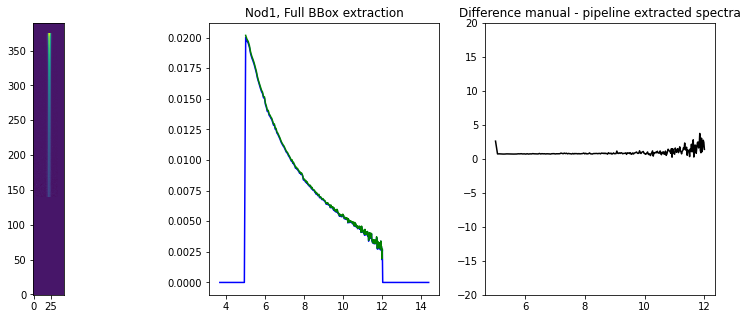

In [190]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=[14,5])
ax[0].imshow(photom_sub, origin='lower', interpolation='None')
ax[1].plot(lam_vec, xsub_cal, 'b-', label='manual extraction')
ax[1].plot(xsub_pipe.spec[0].spec_table['WAVELENGTH'], xsub_pipe.spec[0].spec_table['FLUX'], 'g-', label='pipeline extraction')
ax[1].set_title('Nod1, Full BBox extraction')

#interpolate the two onto the same grid so we can look at the difference
f = interp1d(lam_vec, xsub_cal, fill_value='extrapolate')
ixsub_cal = f(xsub_pipe.spec[0].spec_table['WAVELENGTH'])

diff = ((xsub_pipe.spec[0].spec_table['FLUX'] - ixsub_cal) / xsub_pipe.spec[0].spec_table['FLUX']) * 100.

ax[2].plot(xsub_pipe.spec[0].spec_table['WAVELENGTH'], diff, 'k-')
ax[2].set_title('Difference manual - pipeline extracted spectra')
ax[2].set_ylim([-20., 20.])

fig.show()

We check that the ratio between the 2 is on average <= 1 per cent in the core range between 5 and 10 micron.

In [191]:
inds = (xsub_pipe.spec[0].spec_table['WAVELENGTH'] >= 5.0) & (xsub_pipe.spec[0].spec_table['WAVELENGTH'] <= 10.)
assert np.mean(diff[inds]) <= 1.0, "Mean difference between pipeline and manual extraction >= 1 per cent in 5-10 um. CHECK."

2020-12-15 15:11:10,556 - stpipe - WARNING - /Users/skendrew/anaconda3/envs/jwst0.16.2/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



------------------------------**END OF TEST PART 1**----------------------------------------------

#### Test 2: Nodded observation, two exposures

In this second test we use both nodded observations. In this scenarion, the nods are used as each other's background observations and we need to ensure that the extraction aperture is placed in the right position with a realistic aperture for both nods.

We will re-run the first steps of the Spec2Pipeline, so that the nods are used as each other's backgrounds. Then we will run them both through the extract_1d() step with the default parameters, checking:
* the location of the aperture
* the extraction width



In [192]:
xsub_pipe?

2020-12-15 15:32:51,994 - stpipe - WARNING - /Users/skendrew/anaconda3/envs/jwst0.16.2/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)

